# Halotools Demo

In [1]:
%matplotlib inline

## Working with halo catalogs

Halotools keeps a persistent memory of your halo catalogs. You can access any snapshot in your cache as follows:

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift = 0)

Tabular data storing the actual halo information is stored in the `halo_table` attribute:

In [3]:
print(halocat.halo_table[0:9])

halo_vmax_firstacc halo_dmvir_dt_tdyn ... halo_hostid halo_mvir_host_halo
------------------ ------------------ ... ----------- -------------------
            952.39            10670.0 ...  3060299107           1.643e+14
            823.11            12860.0 ...  3060312953           1.589e+14
            799.42             5633.0 ...  3058440575           1.144e+14
            679.37            14900.0 ...  3058441456           9.709e+13
            735.68             3519.0 ...  3058452345           8.527e+13
            696.86             6331.0 ...  3058463669           8.426e+13
            681.43             5579.0 ...  3058683023           8.357e+13
            668.98             5497.0 ...  3060115960           7.795e+13
            654.46             8205.0 ...  3058477222           7.284e+13


There is also extensive metadata bound to all cached halo catalogs. For example, the `processing_notes` attribute stores a plain-language description of how the initial halo catalog was reduced:

In [4]:
print(halocat.processing_notes)

Catalog only contains (sub)halos with Mpeak greater than 300 particles. The following columns have been divided by 1000 to convert them from the kpc/h units provided in the original ASCII source to the Mpc/h units assumed by Halotools:  halo_rvir, halo_rs, halo_xoff


## What is the NFW concentration of a Milky Way halo?

In [5]:
milky_way_mask = ((halocat.halo_table['halo_upid'] == -1) & 
                  (halocat.halo_table['halo_mpeak'] > 1e12) & 
                  (halocat.halo_table['halo_mpeak'] < 2e12)
                  )

In [6]:
milky_way_halos = halocat.halo_table[milky_way_mask]

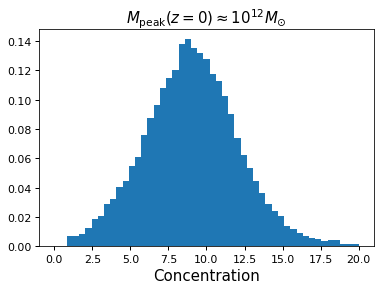

In [7]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(milky_way_halos['halo_nfw_conc'],
           bins = np.linspace(0, 20, 50), normed=True)
xlabel = ax.set_xlabel('Concentration', size=15)
title = ax.set_title(r'$M_{\rm peak}(z=0)\approx10^{12}M_{\odot}$', size=15)

## Populating halo catalogs with mock galaxies 

Halotools ships with a handful of pre-built galaxy-halo models, each of which is an implementation of some specific publication in the literature. 

In [8]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
model = PrebuiltSubhaloModelFactory('behroozi10', redshift=0)

All Halotools models have a `populate_mock` method that creates a Monte Carlo realization of a galaxy population based on the model. The syntax is the same regardless of the features of the model. 

In [9]:
model.populate_mock(halocat)

Calling the `populate_mock` method creates a `mock` attribute. You can access the galaxies in the mock via the `galaxy_table` attribute:

In [10]:
print(model.mock.galaxy_table[0:9])

halo_upid halo_hostid halo_mpeak  halo_x ...   vy      vz   galid stellar_mass
--------- ----------- ---------- ------- ... ------ ------- ----- ------------
       -1  3060299107  1.643e+14  35.725 ... -34.49  -82.51     0   2.1798e+11
       -1  3060312953  1.589e+14 45.2089 ... 264.96 -132.11     1  1.09793e+11
       -1  3058440575  1.144e+14  21.812 ... 104.38  -61.29     2  1.01855e+11
       -1  3058441456  9.709e+13 26.1803 ...  78.85  423.44     3  1.12726e+11
       -1  3058452345  8.527e+13 1.74397 ... 238.52  179.34     4  7.97116e+10
       -1  3058463669  8.439e+13 10.2739 ... 186.67 -187.27     5  1.59603e+11
       -1  3058683023  8.357e+13 12.0235 ... -77.55 -386.58     6  1.72298e+11
       -1  3060115960  7.795e+13 45.8238 ... 179.51   64.62     7  7.77795e+10
       -1  3058477222  7.284e+13 14.5065 ... 239.24 -397.53     8  1.03389e+11


## What is the stellar mass of a Milky Way halo?

In [11]:
milky_way_central_mask = ((model.mock.galaxy_table['halo_upid'] == -1) & 
                  (model.mock.galaxy_table['halo_mpeak'] > 1e12) & 
                  (model.mock.galaxy_table['halo_mpeak'] < 2e12)
                  )
milky_way_centrals = model.mock.galaxy_table[milky_way_central_mask]

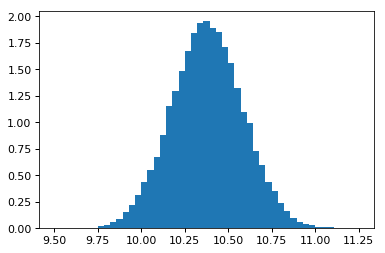

In [12]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(milky_way_centrals['stellar_mass']), 
           bins = np.linspace(9.5, 11.25, 50), normed=True)

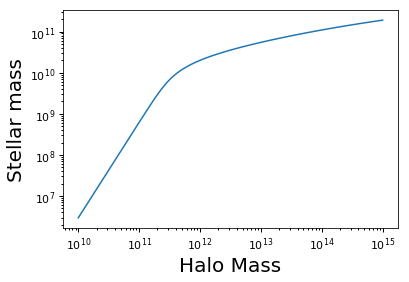

In [13]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

x = np.logspace(10, 15, 100)
y = model.mean_stellar_mass(prim_haloprop = x)

__=ax.plot(x, y, label = 'Behroozi10')

xlabel = ax.set_xlabel('Halo Mass', size=20)
ylabel = ax.set_ylabel('Stellar mass', size=20)

## Counting cluster satellites

In [14]:
from halotools.utils import group_member_generator

In [15]:
sample_mask = model.mock.galaxy_table['stellar_mass'] > 5e9
sample = model.mock.galaxy_table[sample_mask]

In [16]:
sample.sort(['halo_hostid', 'halo_upid'])
gen = group_member_generator(sample, 'halo_hostid', [])

richness = np.zeros(len(sample), dtype = int)
for istart, iend, member_props in gen:
    richness[istart:iend] = iend-istart-1

In [17]:
sample['num_satellites'] = richness

In [18]:
cluster_mask = ((sample['halo_upid'] == -1) & 
                  (sample['halo_mpeak'] > 1e14))
clusters = sample[cluster_mask]

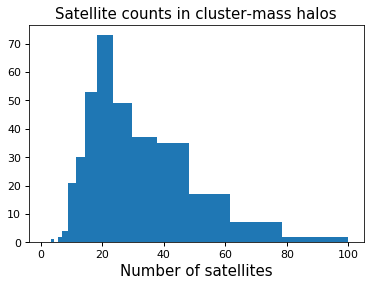

In [19]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(clusters['num_satellites'], bins = np.logspace(0, 2, 20))
__=ax.set_xlabel('Number of satellites', size = 15)
__=ax.set_title('Satellite counts in cluster-mass halos', size=15)

## Calculating two-point clustering

In [20]:
from halotools.mock_observables import tpcf, return_xyz_formatted_array

In [21]:
mask1 = ((model.mock.galaxy_table['stellar_mass'] > 5e9) & 
         (model.mock.galaxy_table['stellar_mass'] < 1e10))
s1 = model.mock.galaxy_table[mask1]
mask2 = ((model.mock.galaxy_table['stellar_mass'] > 5e10) & 
         (model.mock.galaxy_table['stellar_mass'] < 1e11))
s2 = model.mock.galaxy_table[mask2]
mask3 = ((model.mock.galaxy_table['stellar_mass'] > 1e11) & 
         (model.mock.galaxy_table['stellar_mass'] < 1e12))
s3 = model.mock.galaxy_table[mask3]

In [22]:
pos1 = return_xyz_formatted_array(s1['x'], s1['y'], s1['z'])
pos2 = return_xyz_formatted_array(s2['x'], s2['y'], s2['z'])
pos3 = return_xyz_formatted_array(s3['x'], s3['y'], s3['z'])

In [23]:
rbins = np.logspace(-1, 1.25, 15)
r = (rbins[1:] + rbins[:-1])/2.

In [24]:
xi1 = tpcf(pos1, rbins, period = model.mock.Lbox, num_threads = 'max')

In [25]:
xi2 = tpcf(pos2, rbins, period = model.mock.Lbox, num_threads = 'max')

In [26]:
xi3 = tpcf(pos3, rbins, period = model.mock.Lbox, num_threads = 'max')

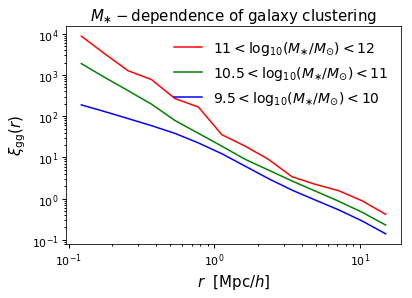

In [27]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

__=ax.plot(r, xi3, 
         label=r'$11 < \log_{10}(M_{\ast}/M_{\odot}) < 12$', color='red')
__=ax.plot(r, xi2, 
         label=r'$10.5 < \log_{10}(M_{\ast}/M_{\odot}) < 11$', color='green')
__=ax.plot(r, xi1, 
         label=r'$9.5 < \log_{10}(M_{\ast}/M_{\odot}) < 10$', color='blue')


xlabel = ax.set_xlabel(r'$r  $  $[{\rm Mpc}/h]$', size=15)
ylabel = ax.set_ylabel(r'$\xi_{\rm gg}(r)$', size=15)

plt.legend(loc='best', fontsize = 14)
title = ax.set_title(r'$M_{\ast}-$dependence of galaxy clustering', size=15)

In [28]:
from halotools.mock_observables import tpcf_one_two_halo_decomp 

In [29]:
host_halo_IDs = model.mock.galaxy_table['halo_hostid'][mask1]

In [30]:
xi_1h, xi_2h = tpcf_one_two_halo_decomp(pos1, host_halo_IDs, rbins, 
                                        period=model.mock.Lbox, num_threads = 'max')

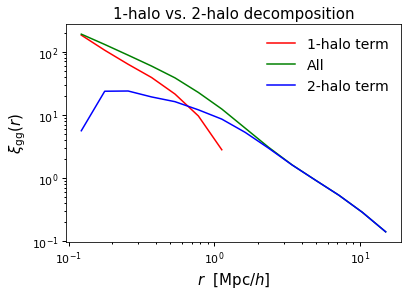

In [31]:
fig, ax = plt.subplots(1, 1)

ax.loglog()

__=ax.plot(r, xi_1h, label='1-halo term', color='red')
__=ax.plot(r, xi1, 
         label='All', color='green')
__=ax.plot(r, xi_2h, label='2-halo term', color='blue')


xlabel = ax.set_xlabel(r'$r  $  $[{\rm Mpc}/h]$', fontsize=15)
ylabel = ax.set_ylabel(r'$\xi_{\rm gg}(r)$', fontsize=15)

plt.legend(loc='best', fontsize = 14)
title = ax.set_title('1-halo vs. 2-halo decomposition', size=15)

## Example of how to build your own model: Galaxy sizes

One of the core features of Halotools is to provide a generalized platform you can use to build models of the galaxy-halo connection. The code is built around a factory design pattern: you choose a set of features you are interested in modeling, you pass a set of *component models* to the factory, and the factory returns a *composite model* that can be used to directly populate halo catalogs with galaxies. 

### Define a model for the size of a galaxy

In [32]:
class Size(object):

    def __init__(self):

        self._mock_generation_calling_sequence = ['assign_size']
        self._galprop_dtypes_to_allocate = np.dtype([('galsize', 'f4')])
        self.list_of_haloprops_needed = ['halo_spin']
        self.param_dict = {'spin_to_size_ratio': 5.}

    def assign_size(self, **kwargs):
        table = kwargs['table']
        table['galsize'][:] = table['halo_spin']/self.param_dict['spin_to_size_ratio']

In [33]:
galaxy_size = Size()

### Choose a baseline pre-built model 

In [34]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
behroozi10_model = PrebuiltSubhaloModelFactory('behroozi10')

### Now use the factory to add the new `size` feature onto the baseline model:

In [35]:
from halotools.empirical_models import SubhaloModelFactory

In [36]:
new_model = SubhaloModelFactory(baseline_model_instance = behroozi10_model,
                            size = galaxy_size)

### Your new model can generate a mock with the same syntax

In [37]:
new_model.populate_mock(halocat)

The model has a set of parameters controlling the behavior

In [38]:
new_model.param_dict

{u'scatter_model_param1': 0.2,
 u'smhm_beta_0': 0.43,
 u'smhm_beta_a': 0.18,
 u'smhm_delta_0': 0.56,
 u'smhm_delta_a': 0.18,
 u'smhm_gamma_0': 1.54,
 u'smhm_gamma_a': 2.52,
 u'smhm_m0_0': 10.72,
 u'smhm_m0_a': 0.59,
 u'smhm_m1_0': 12.35,
 u'smhm_m1_a': 0.3,
 'spin_to_size_ratio': 5.0}

If you change the values of these parameters, and repopulate the snapshot, you will get a universe with different properties. 

In [39]:
new_model.param_dict['spin_to_size_ratio'] = 4.0

In [40]:
new_model.mock.populate()

Notice that once the mock is built the first time, you now use the `populate` method of the `mock` object, which saves lots of pre-processing time that only needs to be done once. 

In [41]:
%timeit new_model.mock.populate()

1 loop, best of 3: 261 ms per loop


## Example of how to build your own model: HOD with subhalo information

In [42]:
from halotools.empirical_models import PrebuiltHodModelFactory
model = PrebuiltHodModelFactory('leauthaud11', redshift=0)

for key in model.model_dictionary:
    print(key, model.model_dictionary[key].__class__.__name__)

(u'centrals_occupation', 'Leauthaud11Cens')
(u'satellites_occupation', 'Leauthaud11Sats')
(u'centrals_profile', 'TrivialPhaseSpace')
(u'satellites_profile', 'NFWPhaseSpace')


In [43]:
model.populate_mock(halocat)

In [44]:
model.mock.populate()

In [45]:
from halotools.empirical_models import SubhaloPhaseSpace

gal_type = 'satellites'
host_haloprop_bins = np.logspace(10.5, 15.1, 15)
subhalo_profile_model = SubhaloPhaseSpace('satellites', host_haloprop_bins)

In [46]:
from halotools.empirical_models import HodModelFactory

new_model_dictionary = model.model_dictionary
new_model_dictionary['satellites_profile'] = subhalo_profile_model

new_model = HodModelFactory(**new_model_dictionary)

In [47]:
new_model.populate_mock(halocat)

In [48]:
new_model.mock.populate()